# Implementation

Author: Jørgen Schartum Dokken

This implementation is an adaptation of the work in {cite}`fundamentals-FenicsTutorial` to DOLFINx.

In this section, you will learn:
- How to use the built-in meshes in DOLFINx
- How to create a spatially varying Dirichlet boundary conditions on the whole domain boundary
- How to define a weak formulation of your PDE
- How to solve the resulting system of linear equations
- How to visualize the solution using a variety of tools
- How to compute the $L^2(\Omega)$ error and the error at mesh vertices

## Interactive tutorials
```{admonition} Run the tutorial as Jupyter notebook in browser
As this book has been published as a Jupyter Book, each code can be run in your browser as a Jupyter notebook.
To start such a notebook click the rocket symbol in the top right corner of the relevant tutorial.
```

The Poisson problem has so far featured a general domain $\Omega$ and general functions $u_D$ for
the boundary conditions and $f$ for the right hand side.
Therefore, we need to make specific choices of $\Omega, u_D$ and $f$.
A wise choice is to construct a problem  with a known analytical solution,
so that we can check that the computed solution is correct.
The primary candidates are lower-order polynomials.
The continuous Galerkin finite element spaces of degree $r$ will exactly reproduce polynomials of degree $r$.
<!-- Particularly, piecewise linear continuous Galerkin finite elements are able to exactly reproduce a quadratic polynomial on
a uniformly partitioned mesh. -->
 We use this fact to construct a quadratic function in $2D$. In particular we choose

$$
\begin{align}
 u_e(x,y)=1+x^2+2y^2
 \end{align}
$$

Inserting $u_e$ in the original boundary problem, we find that

$$
\begin{align}
    f(x,y)= -6,\qquad u_D(x,y)=u_e(x,y)=1+x^2+2y^2,
\end{align}
$$

regardless of the shape of the domain as long as we prescribe
$u_e$ on the boundary.

For simplicity, we choose the domain to be a unit square $\Omega=[0,1]\times [0,1]$

This simple but very powerful method for constructing test problems is called _the method of manufactured solutions_.
First pick a simple expression for the exact solution, plug into
the equation to obtain the right-hand side (source term $f$).
Then solve the equation with this right hand side, and using the exact solution as boundary condition.
Finally, we create a program that tries to reproduce the exact solution.

Note that in many cases, it can be hard to determine if the program works if it produces an error of size
$10^{-5}$ on a $20 \times 20$ grid.
However, since we are using Sobolev spaces, we usually know about the numerical errors _asymptotic properties_.
For instance that it is proportional to $h^2$ if $h$ is the size of a cell in the mesh.
We can then compare the error on meshes with different $h$-values to see if the asymptotic behavior is correct.
This technique will be explained in detail in the chapter [Improving your fenics code](./../chapter4/convergence).

However, in cases where we have a solution we know that should have no approximation error,
we know that the solution should be produced to machine precision by the program.

A major difference between a traditional FEniCS code and a FEniCSx code,
is that one is not advised to use the wildcard import.
We will see this throughout this first example.

## Generating  simple meshes
The next step is to define the discrete domain, _the mesh_.
We do this by importing one of the built-in mesh generators.
We will build a {py:func}`unit square mesh<dolfinx.mesh.create_unit_square>`, i.e. a mesh spanning $[0,1]\times[0,1]$.
It can consist of either triangles or quadrilaterals.

In [1]:
from mpi4py import MPI
from dolfinx import mesh
import numpy

domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)

Note that in addition to give how many elements we would like to have in each direction.
We also have to supply the _MPI-communicator_.
This is to specify how we would like the program to behave in parallel.
If we supply {py:data}`MPI.COMM_WORLD<mpi4py.MPI.COMM_WORLD>` we create a single mesh,
whose data is distributed over the number of processors we would like to use.
We can for instance run the program in  parallel on two processors by using `mpirun`, as:
``` bash
 mpirun -n 2 python3 t1.py
```
However, if we would like to create a separate mesh on each processor,
we can use {py:data}`MPI.COMM_SELF<mpi4py.MPI.COMM_SELF>`.
This is for instance  useful if we run a small problem, and would like to run it with multiple parameters.

## Defining the finite element function space
 Once the mesh has been created, we can create the finite element function space $V$.
The finite element function space does not need to be the same as the one used to describe the mesh.
DOLFINx supports a wide range of arbitrary order finite element function spaces, see:
[Supported elements in DOLFINx](https://defelement.org/lists/implementations/basix.ufl.html)
for an extensive list.
To create a function space, we need to specify what mesh the space is defined on,
what element famil the space is based on, and the degree of the element.
These can for instance be defned through a tuple `("family", degree)`, as shown below

In [2]:
from dolfinx import fem

V = fem.functionspace(domain, ("Lagrange", 1))

Further details about specification/customization of this tuple, see {py:class}`dolfinx.fem.ElementMetaData`.

##  Dirichlet boundary conditions
Next, we create a function that will hold the Dirichlet boundary data, and use interpolation to
fill it with the appropriate data.

In [3]:
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)

We now have the boundary data (and in this case the solution of the finite element problem)
represented in the discrete function space.
Next we would like to apply the boundary values to all degrees of freedom that are on the
boundary of the discrete domain.
We start by identifying the facets (line-segments) representing the outer boundary,
using {py:func}`dolfinx.mesh.exterior_facet_indices`.
We start by creating the facet to cell connectivity required to determine boundary facets by
calling {py:meth}`dolfinx.mesh.Topology.create_connectivity`.

In [4]:
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

For the current problem, as we are using the first order Lagrange function space,
the degrees of freedom are located at the vertices of each cell, thus each facet contains two degrees of freedom.

To find the local indices of these degrees of freedom, we use {py:func}`dolfinx.fem.locate_dofs_topological`
which takes in the function space, the dimension of entities in the mesh we would like to identify and the local entities.
```{admonition} Local ordering of degrees of freedom and mesh vertices
Many people expect there to be a 1-1 correspondence between the mesh coordinates and the coordinates of the degrees of freedom.
However, this is only true in the case of `Lagrange` 1 elements on a first order mesh.
Therefore, in DOLFINx we use separate local numbering for the mesh coordinates and the dof coordinates.
To obtain the local dof coordinates we can use
{py:meth}`V.tabulate_dof_coordinates()<dolfinx.fem.FunctionSpace.tabulate_dof_coordinates>`,
while the ordering of the local vertices can be obtained by {py:attr}`mesh.geometry.x<dolfinx.mesh.Geometry.x>`.
```
With this data at hand, we can create the Dirichlet boundary condition

In [5]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

## Defining the trial and test function

In mathematics, we distinguish between trial and test spaces $V$ and $\hat{V}$.
The only difference in the present problem is the boundary conditions.
In FEniCSx, we do not specify boundary conditions as part of the function space,
so it is sufficient to use a common space for the trial and test function.

We use the {py:mod}`Unified Form Language<ufl>` (UFL) to specify the varitional formulations.
See {cite}`fundamentals-ufl2014` for more details.

In [6]:
import ufl

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

## Defining the source term
As the source term is constant over the domain, we use {py:class}`dolfinx.fem.Constant`

In [7]:
from dolfinx import default_scalar_type

f = fem.Constant(domain, default_scalar_type(-6))

```{admonition} Compilation speed-up
Instead of wrapping $-6$ in a {py:class}`dolfinx.fem.Constant`, we could simply define $f$ as `f=-6`.
However, if we would like to change this parameter later in the simulation,
we would have to redefine our variational formulation.
The {py:attr}`dolfinx.fem.Constant.value` allows us to update the value in $f$ by using `f.value=5`.
Additionally, by indicating that $f$ is a constant, we speed of compilation of the variational
formulations required for the created linear system.
```

## Defining the variational problem
As we now have defined all variables used to describe our variational problem, we can create the weak formulation

In [8]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

Note that there is a very close correspondence between the Python syntax and the mathematical syntax
$\int_{\Omega} \nabla u \cdot \nabla v ~\mathrm{d} x$ and $\int_{\Omega}fv~\mathrm{d} x$.
The integration over the domain $\Omega$ is defined by using {py:func}`ufl.dx`, an integration
{py:class}`measure<ufl.Measure>` over all cells of the mesh.

This is the key strength of FEniCSx:
the formulas in the variational formulation translate directly to very similar Python code,
a feature that makes it easy to specify and solve complicated PDE problems.

## Expressing inner products
The inner product $\int_\Omega \nabla u \cdot \nabla v ~\mathrm{d} x$ can be expressed in various ways in UFL.
We have used the notation `ufl.dot(ufl.grad(u), ufl.grad(v))*ufl.dx`.
The {py:func}`dot<ufl.dot>` product in UFL computes the sum (contraction) over the last index
of the first factor and first index of the second factor.
In this case, both factors are tensors of rank one (vectors) and so the sum is just over
the single index of both $\nabla u$ and $\nabla v$.
To compute an inner product of matrices (with two indices),
one must use the function {py:func}`ufl.inner` instead of {py:func}`ufl.dot`.
For real-valued vectors, {py:func}`ufl.dot` and {py:func}`ufl.inner` are equivalent.

```{admonition} Complex numbers
In DOLFINx, one can solve complex number problems by using an installation of PETSc using complex numbers.
For variational formulations with complex numbers, one cannot use {py:func}`ufl.dot` to compute inner products.
One has to use {py:func}`ufl.inner`, with the test-function as the second input argument for {py:func}`ufl.inner`.
See [Running DOLFINx in complex mode](./complex_mode) for more information.
```


## Forming and solving the linear system

Having defined the finite element variational problem and boundary condition,
we can create our {py:class}`LinearProblem<dolfinx.fem.petsc.LinearProblem>` to solve the variational problem:
Find $u_h\in V$ such that $a(u_h, v)==L(v) \quad \forall v \in \hat{V}$.
We will use {py:mod}`PETSc<petsc4py.PETSc>` as our linear algebra backend, using a direct solver (LU-factorization).
See the [PETSc-documentation](https://petsc.org/main/docs/manual/ksp/?highlight=ksp#ksp-linear-system-solvers) of the method for more information.
PETSc is not a required dependency of DOLFINx, and therefore we explicitly import the DOLFINx wrapper for interfacing with PETSc.
To ensure that the options passed to the {py:class}`LinearProblem<dolfinx.fem.petsc.LinearProblem>`
is only used for the given KSP solver, we pass a **unique** option prefix as well.

In [10]:
from dolfinx.fem.petsc import LinearProblem

problem = LinearProblem(
    a,
    L,
    bcs=[bc],
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
    )
    #petsc_options_prefix="Poisson",

uh = problem.solve()

ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenics-py312/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenics-py312/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenics-py312/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenics-py312/lib' ignored


Using {py:meth}`problem.solve()<dolfinx.fem.petsc.LinearProblem.solve>` we solve the linear system of equations and
return a {py:class}`Function<dolfinx.fem.Function>` containing the solution.

(error-norm)=
## Computing the error
Finally, we want to compute the error to check the accuracy of the solution.
We do this by comparing the finite element solution `u` with the exact solution.
First we interpolate the exact solution into a function space that contains it

In [11]:
V2 = fem.functionspace(domain, ("Lagrange", 2))
uex = fem.Function(V2, name="u_exact")
uex.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)

We compute the error in two different ways.
First, we compute the $L^2$-norm of the error, defined by $E=\sqrt{\int_\Omega (u_D-u_h)^2\mathrm{d} x}$.
We use UFL to express the $L^2$-error, and use {py:func}`dolfinx.fem.assemble_scalar` to compute the scalar value.
In DOLFINx, {py:func}`assemble_scalar<dolfinx.fem.assemble_scalar>`
only assembles over the cells on the local process.
This means that if we use 2 processes to solve our problem,
we need to accumulate the local contributions to get the global error (on one or all processes).
We can do this with the {py:meth}`Comm.allreduce<mpi4py.MPI.Comm.allreduce>` function.

In [12]:
L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenics-py312/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenics-py312/lib' ignored


Secondly, we compute the maximum error at any degree of freedom.
As the finite element function $u$ can be expressed as a linear combination of basis functions $\phi_j$,
spanning the space $V$: $ u = \sum_{j=1}^N U_j\phi_j.$
By writing {py:meth}`problem.solve()<dolfinx.fem.petsc.LinearProblem.sovle>`
we compute all the coefficients $U_1,\dots, U_N$.
These values are known as the _degrees of freedom_ (dofs).
We can access the degrees of freedom by accessing the underlying vector in `uh`.
However, as a second order function space has more dofs than a linear function space,
we cannot compare these arrays directly.
As we already have interpolated the exact solution into the first order space when creating the boundary condition,
we can compare the maximum values at any degree of freedom of the approximation space.

In [13]:
error_max = numpy.max(numpy.abs(uD.x.array - uh.x.array))
if domain.comm.rank == 0:  # Only print the error on one process
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_L2 : 8.24e-03
Error_max : 5.33e-15


## Plotting the mesh using pyvista
We will visualizing the mesh using [pyvista](https://docs.pyvista.org/), an interface to the VTK toolkit.
We start by converting the mesh to a format that can be used with {py:mod}`pyvista`.
To do this we use the function {py:func}`dolfinx.plot.vtk_mesh`.
It creates the data required to create a {py:class}`pyvista.UnstructuredGrid`.
You can print the current backend and change it with {py:func}`pyvista.set_jupyter_backend`.

In [14]:
import pyvista

print(pyvista.global_theme.jupyter_backend)

trame


In [17]:
from dolfinx import plot

domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

There are several backends that can be used with pyvista, and they have different benefits and drawbacks.
See the [pyvista documentation](https://docs.pyvista.org/user-guide/jupyter/index.html#state-of-3d-interactive-jupyterlab-plotting)
for more information and installation details.

We can now use the {py:class}`pyvista.Plotter` to visualize the mesh. We visualize it by showing it in 2D and warped in 3D.
In the jupyter notebook environment, we use the default setting of `pyvista.OFF_SCREEN=False`,
which will render plots directly in the notebook.

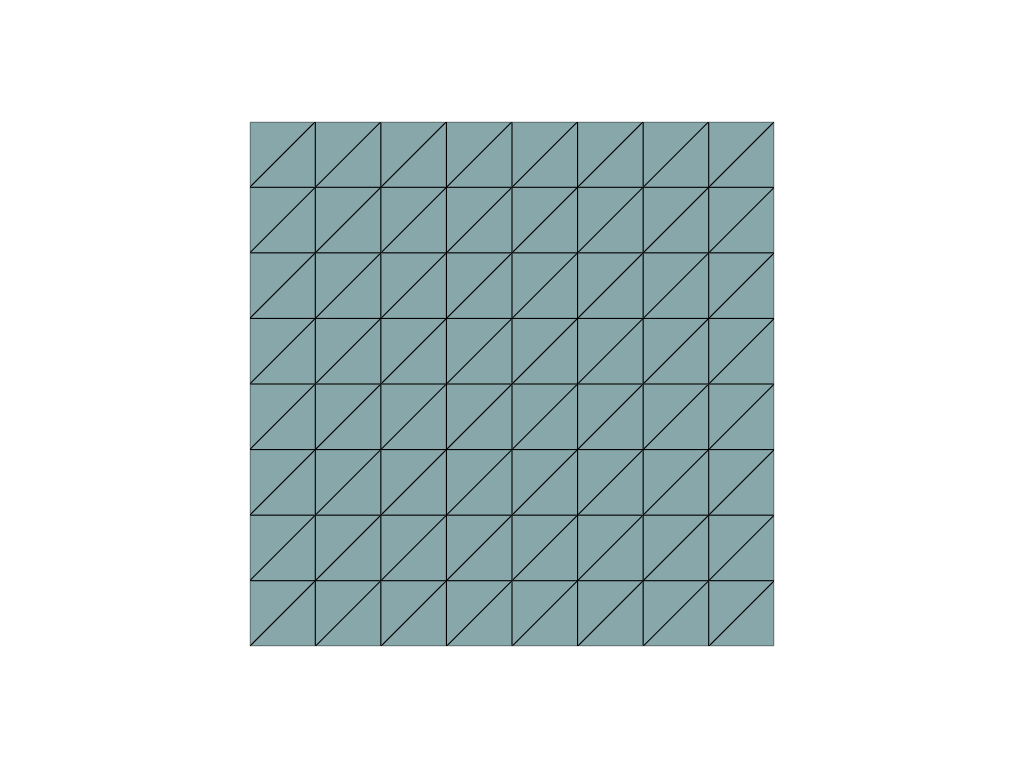

In [18]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

## Plotting a function using pyvista
We want to plot the solution `uh`.
As the function space used to defined the mesh is decoupled from the representation of the mesh,
we create a mesh based on the dof coordinates for the function space `V`.
We use {py:func}`dolfinx.plot.vtk_mesh` with the function space as input to create a mesh with
mesh geometry based on the dof coordinates.

In [19]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

Next, we create the {py:class}`pyvista.UnstructuredGrid` and add the dof-values to the mesh.

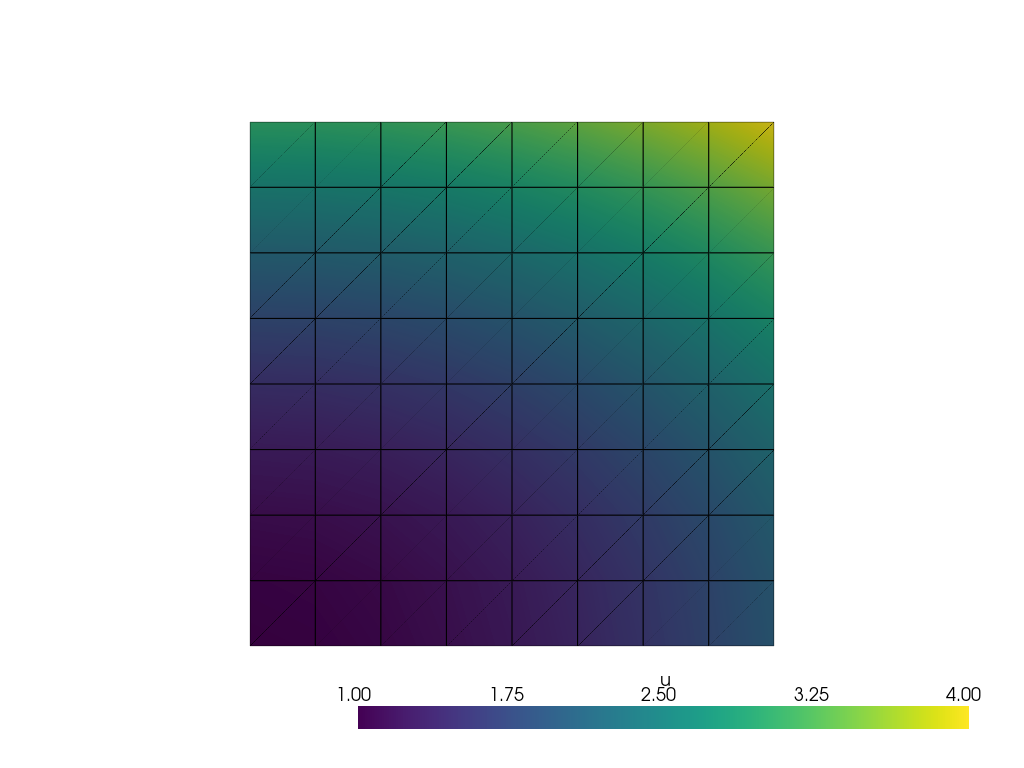

In [20]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

We can also warp the mesh by scalar to make use of the 3D plotting.

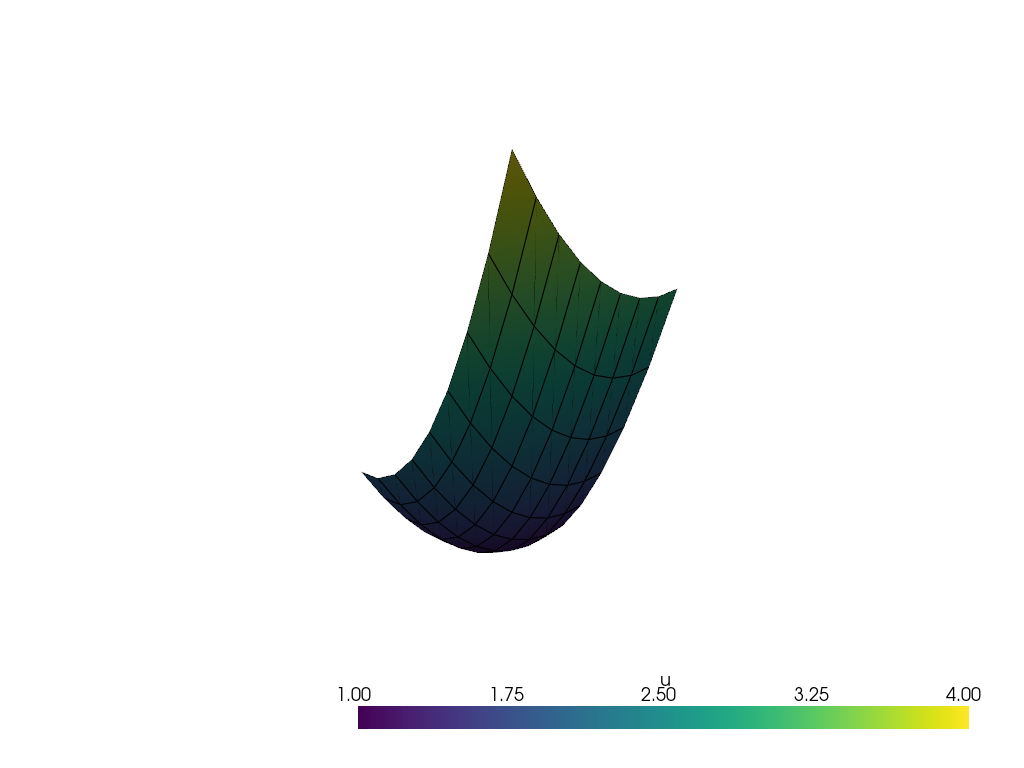

In [21]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()

## External post-processing
For post-processing outside the python code, it is suggested to save the solution to file using either
{py:class}`dolfinx.io.VTXWriter` or {py:class}`dolfinx.io.XDMFFile` and using [Paraview](https://www.paraview.org/).
This is especially suggested for 3D visualization.

In [22]:
from dolfinx import io
from pathlib import Path

results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "fundamentals"
with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0)
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

```{bibliography}
   :filter: cited
   :labelprefix:
   :keyprefix: fundamentals-
```